1. Analyze and Preprocess data - Check if the dataset has missing values or has any other problem.
2. Feature Engineering
3. Sampling Your Data
4. Build Model
    4. a. Try DecisionTree, RandomForest
    4. b. Try other tree-based model like: XGBoost, CatBoost
5. Perform model on training set and test set using gridsearch CV
6. Measure performance of the model.
7. Which metric is your main metric for this problem and why? What is your main model as well as their params and why?


How can I measure your point:
1. Your function is callable and runs correctly
2. The performance of your model (in full pipeline) is acceptable.
3. The data preprocessing is correct or make sense
4. The Feature engineering is correct or make sense
5. Any other additional process will be considered a small plus point.

Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period. Every user is assigned a prediction value that estimates their state of churn at any given time. This value is based on:

User demographic information
Browsing behavior
Historical purchase data among other information
It factors in our unique and proprietary predictions of how long a user will remain a customer. This score is updated every day for all users who have a minimum of one conversion. The values assigned are between 1 and 5.

## Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2.0
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1.0
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5.0
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5.0
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5.0


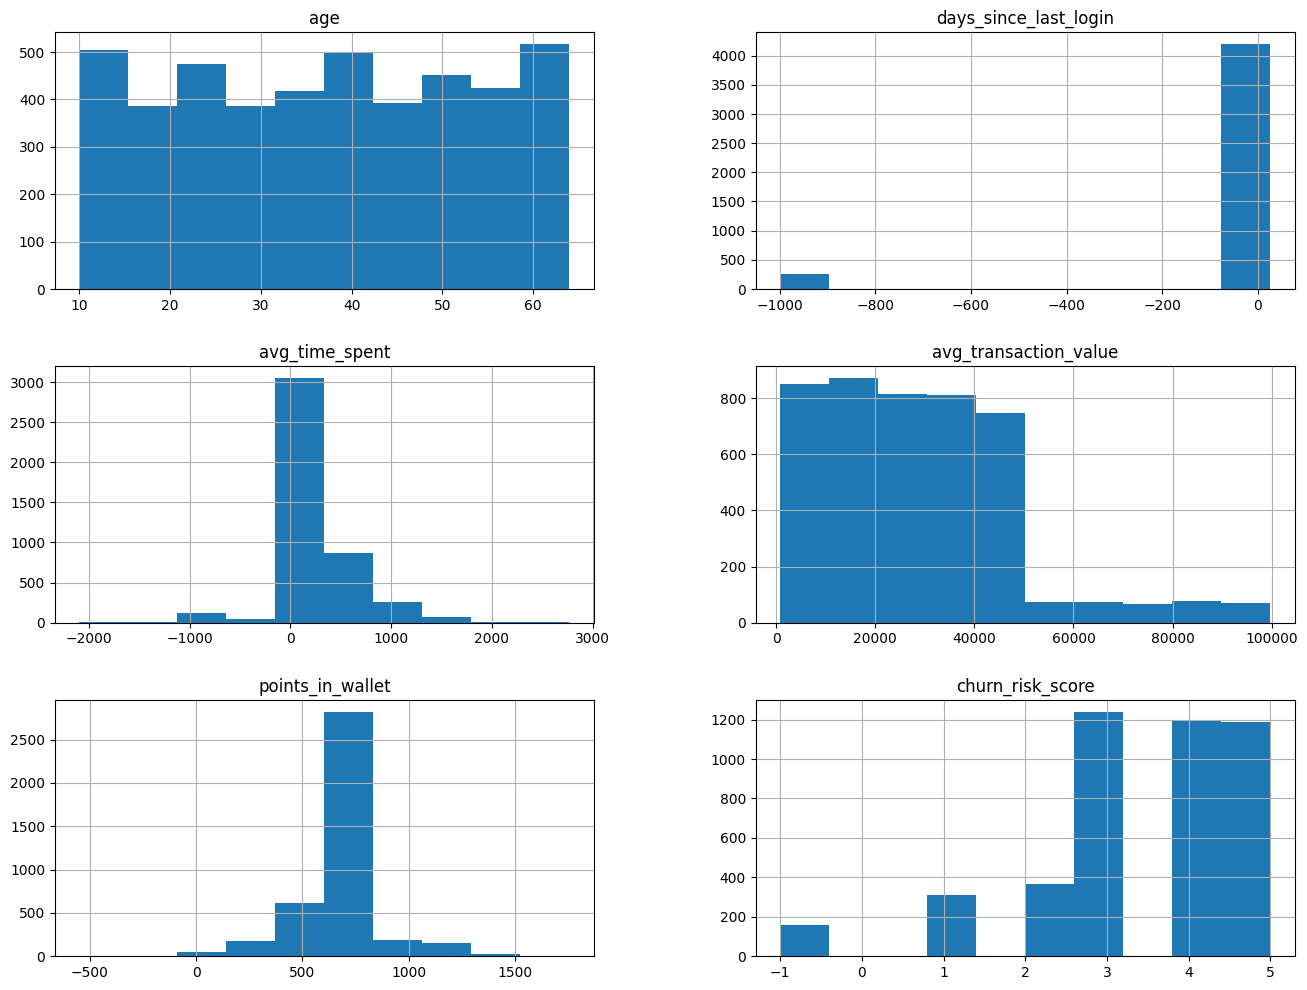

In [2]:
import pandas as pd
PATH = "/content/HomeWork-churn_rate_prediction.csv" # Path to your file

df = pd.read_csv(PATH)
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
#ToDo: Show histogram of dataframe
df.hist(figsize=(16, 12))
df.head()

## Data Analysis

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456 entries, 0 to 4455
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   4456 non-null   object 
 1   Name                          4456 non-null   object 
 2   age                           4456 non-null   int64  
 3   gender                        4456 non-null   object 
 4   security_no                   4456 non-null   object 
 5   region_category               3790 non-null   object 
 6   membership_category           4456 non-null   object 
 7   joining_date                  4455 non-null   object 
 8   joined_through_referral       4455 non-null   object 
 9   referral_id                   4455 non-null   object 
 10  preferred_offer_types         4412 non-null   object 
 11  medium_of_operation           4455 non-null   object 
 12  internet_option               4455 non-null   object 
 13  las

In [4]:
# Get basic statistics of dataframe such as: number of samples, mean, std, min, etc
print(df.describe())

               age  days_since_last_login  avg_time_spent  \
count  4456.000000            4455.000000     4455.000000   
mean     37.156867             -46.660382      252.725399   
std      16.022272             238.143524      396.150799   
min      10.000000            -999.000000    -2093.121606   
25%      23.000000               8.000000       63.670000   
50%      37.000000              12.000000      167.060000   
75%      51.000000              16.000000      366.915000   
max      64.000000              26.000000     2770.560000   

       avg_transaction_value  points_in_wallet  churn_risk_score  
count            4455.000000       4044.000000       4455.000000  
mean            28877.007077        686.303227          3.435017  
std             19607.257449        191.730795          1.441023  
min               806.220000       -549.357498         -1.000000  
25%             13708.590000        615.710000          3.000000  
50%             26658.560000        698.575000  

In [5]:
# Get categorical columns and numerical columns
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(exclude='object').columns
print(f'Number of missing  values: {df.isna().sum().sum()}')

Number of missing  values: 1138


Ta nhận thấy giá trị null khá nhiều nên ta sẽ điền các giá trị null bằng 0

In [6]:
df.fillna(value=0, inplace=True) # điền giá trị bị thiếu bằng 0

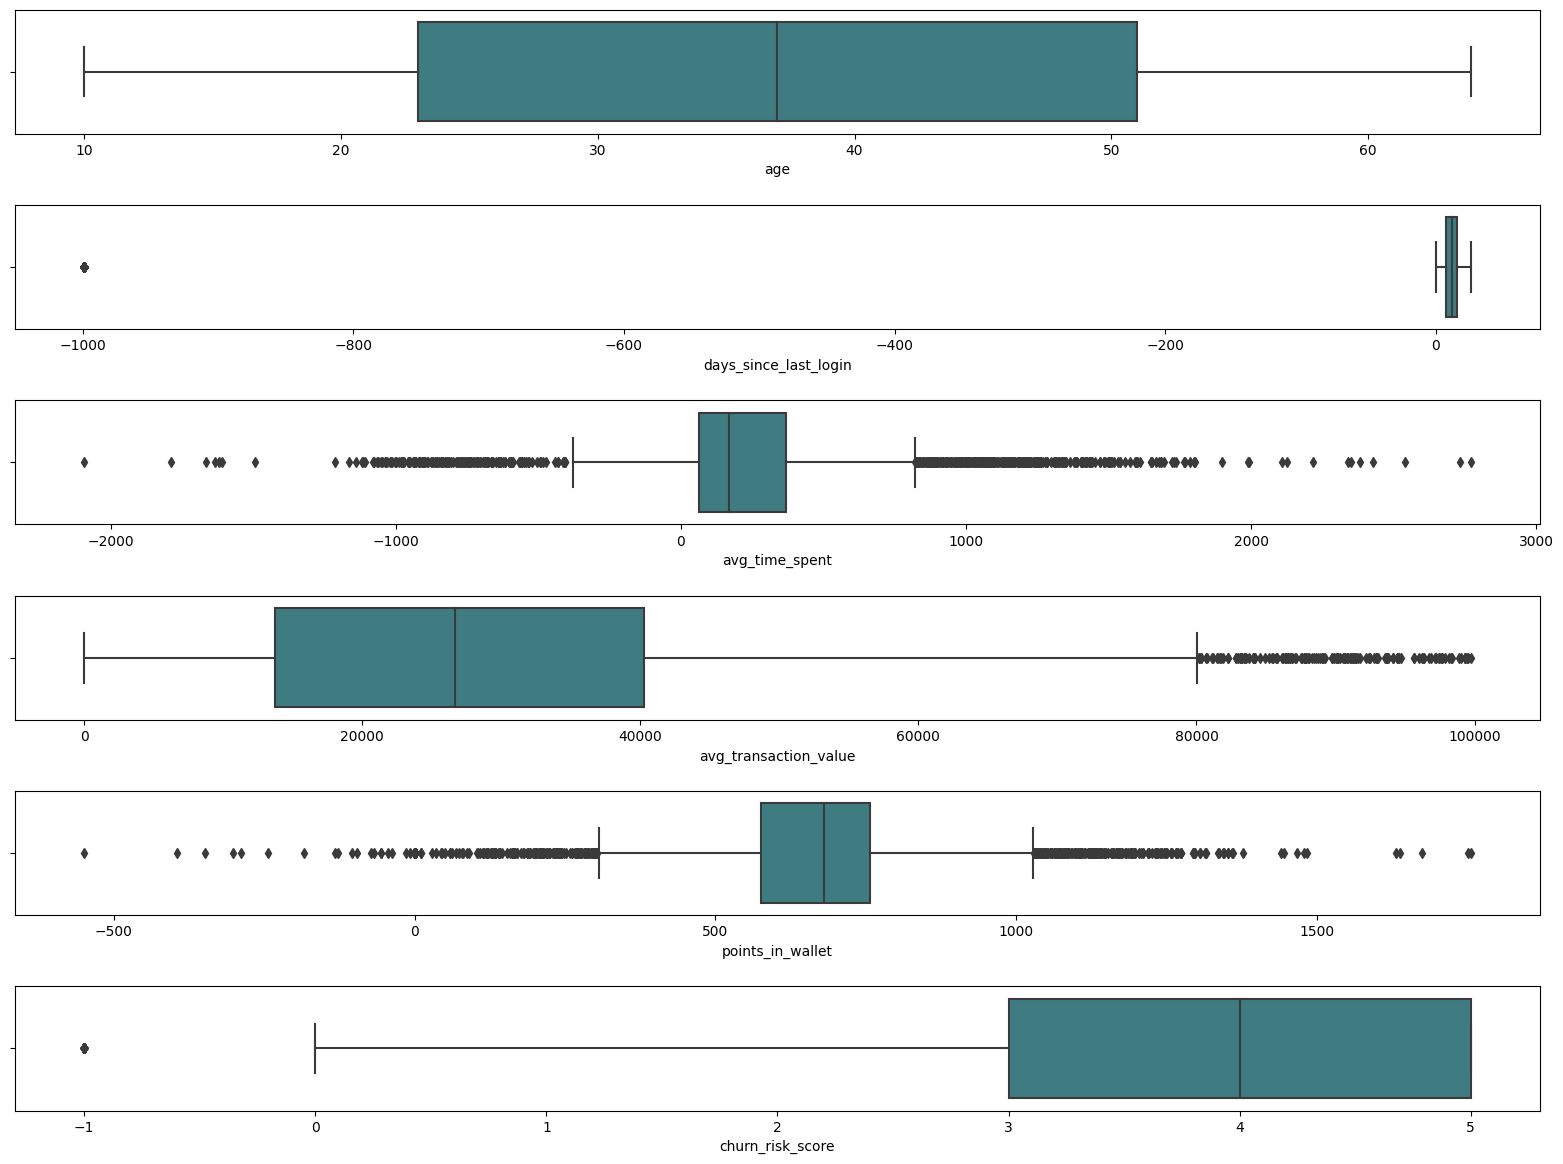

In [7]:
# Boxplot of every numerical columns
fig, axes=plt.subplots(len(numerical_cols), 1, figsize=(16, 2*len(numerical_cols)),sharex=False,sharey=False)
for i, column in enumerate(numerical_cols):
    sns.boxplot(x=column,data=df,palette='crest',ax=axes[i])
plt.tight_layout(pad=2.0)

<ipython-input-8-3857f0723db1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

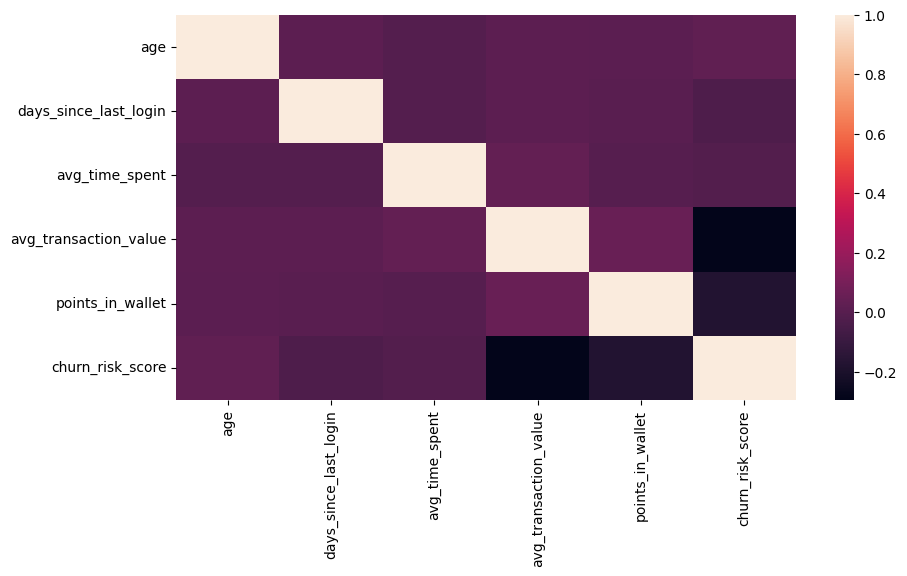

In [8]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr())

## Preprocessing

In [9]:
def preprocessing_data(df):
    """
    Preprocess your data (eg. Drop null datapoints or fill missing data)
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    # Todo: preprocess data
    df = df.drop_duplicates()
    null_values = df.isna().sum().sum()
    if null_values != 0:
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        cols = df.columns
        df = imp_mean.fit_transform(df)
        df = pd.DataFrame(df, columns=cols)  
    return df

In [10]:
df = preprocessing_data(df)
df.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2.0
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,0.00,Yes,No,Yes,Solved,Quality Customer Care,1.0
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5.0
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5.0
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5.0


In [11]:
df = preprocessing_data(df.copy())

## Feature Engineering

<Axes: >

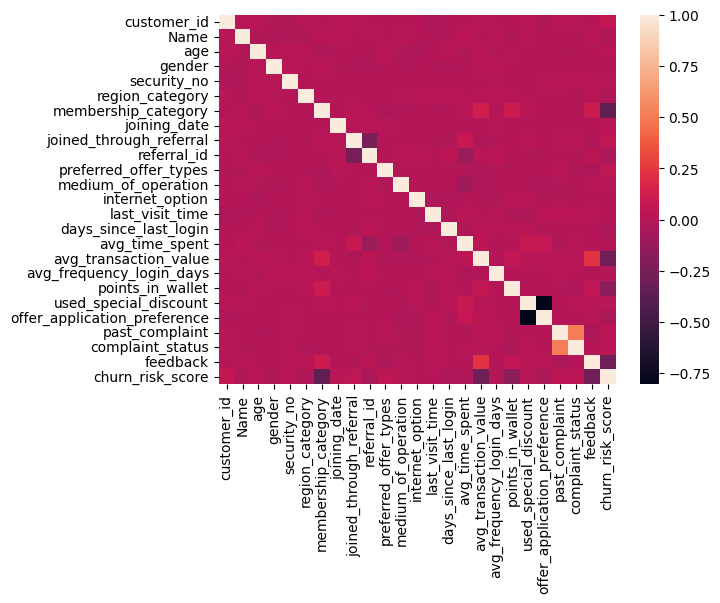

In [12]:
# Heatmap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def apply_feature_engineering(df):
    """
    Apply all feature engineering to transform your data into number
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    # Todo: Normalize your data
    target = df['age']
    categorical_feats = df.select_dtypes(include='object').columns
    for col in categorical_feats:
        df[col] = df[col].astype('category').cat.codes
    df['age'] = target
    return df

df = apply_feature_engineering(df)
sns.heatmap(df.corr())

In [13]:
def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    # Todo: Split data into X and y (using sklearn train_test_split). Return two dataframes
    X = df.drop('age', axis=1, inplace=False)
    y = df['age']
    return X, y

X, y = prepare_X_y(df)

# Apply machine learning model

## Train-test split

In [14]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 2023
TRAIN_SIZE = 0.7

trainX, testX ,trainY, testY = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

array([[<Axes: title={'center': 'customer_id'}>,
        <Axes: title={'center': 'Name'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'security_no'}>],
       [<Axes: title={'center': 'region_category'}>,
        <Axes: title={'center': 'membership_category'}>,
        <Axes: title={'center': 'joining_date'}>,
        <Axes: title={'center': 'joined_through_referral'}>,
        <Axes: title={'center': 'referral_id'}>],
       [<Axes: title={'center': 'preferred_offer_types'}>,
        <Axes: title={'center': 'medium_of_operation'}>,
        <Axes: title={'center': 'internet_option'}>,
        <Axes: title={'center': 'last_visit_time'}>,
        <Axes: title={'center': 'days_since_last_login'}>],
       [<Axes: title={'center': 'avg_time_spent'}>,
        <Axes: title={'center': 'avg_transaction_value'}>,
        <Axes: title={'center': 'avg_frequency_login_days'}>,
        <Axes: title={'center': 'points_in_walle

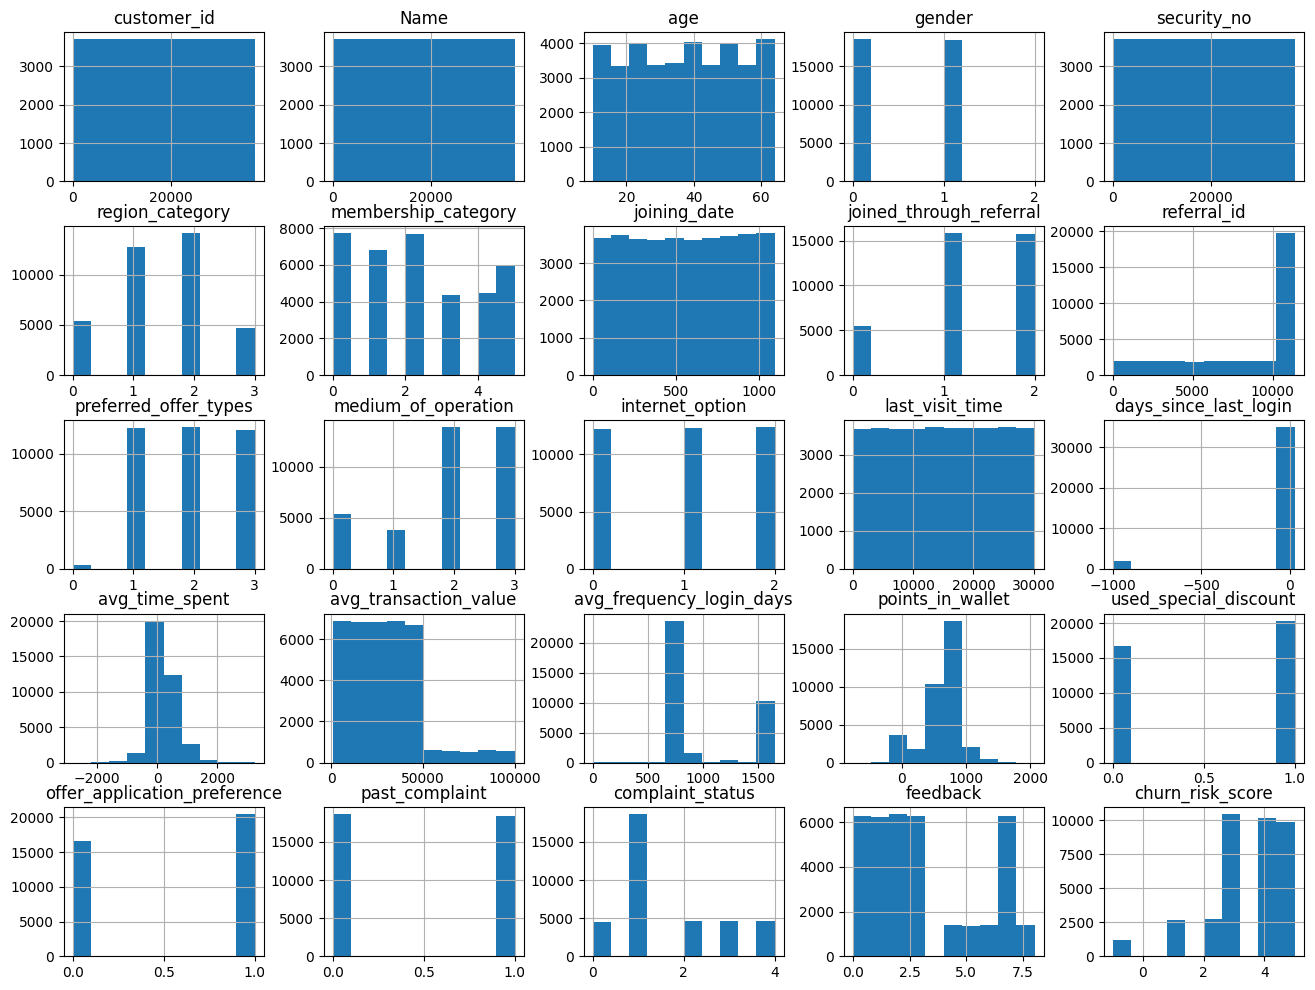

In [ ]:
df.hist(figsize=(16,12))

In [15]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.0 MB/s eta 0:00:00


## Build SK-learn model

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Sử dụng DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(trainX, trainY)
y_pred_dtr = dtr.predict(testX)

# Sử dụng RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(trainX, trainY)
y_pred_rfr = rfr.predict(testX)

# Sử dụng XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(trainX, trainY)
y_pred_xgbr = xgbr.predict(testX)

# Sử dụng CatBoostRegressor
catr = CatBoostRegressor()
catr.fit(trainX, trainY)
y_pred_catr = catr.predict(testX)

Learning rate set to 0.049004
0:	learn: 15.9918593	total: 50.4ms	remaining: 50.4s
1:	learn: 15.9763135	total: 57.1ms	remaining: 28.5s
2:	learn: 15.9601084	total: 63.9ms	remaining: 21.2s
3:	learn: 15.9458966	total: 70.5ms	remaining: 17.6s
4:	learn: 15.9291895	total: 77.4ms	remaining: 15.4s
5:	learn: 15.9115275	total: 84.4ms	remaining: 14s
6:	learn: 15.8922506	total: 91.1ms	remaining: 12.9s
7:	learn: 15.8796275	total: 97.6ms	remaining: 12.1s
8:	learn: 15.8621086	total: 104ms	remaining: 11.5s
9:	learn: 15.8454063	total: 112ms	remaining: 11.1s
10:	learn: 15.8327867	total: 118ms	remaining: 10.6s
11:	learn: 15.8217435	total: 123ms	remaining: 10.1s
12:	learn: 15.8084462	total: 127ms	remaining: 9.63s
13:	learn: 15.8009876	total: 134ms	remaining: 9.43s
14:	learn: 15.7867353	total: 142ms	remaining: 9.33s
15:	learn: 15.7776078	total: 147ms	remaining: 9.04s
16:	learn: 15.7600368	total: 152ms	remaining: 8.81s
17:	learn: 15.7447815	total: 157ms	remaining: 8.54s
18:	learn: 15.7369765	total: 163ms	rem